# 07 - Imaging: Chest X-ray Baseline


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

In [ ]:
# -------------------- Config --------------------
SEED = 42
DATA_DIR = "D:/HealthAI Project/data/Chest X-Rays"   # <--- update if needed (expects train/valid/test)
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 50
INIT_LR = 1e-3
NUM_WORKERS = 2  # use 0 on Windows if you hit issues
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early stopping / checkpointing
MODELS_DIR = "Models/CNN_Model"
os.makedirs(MODELS_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(MODELS_DIR, "best_by_val_acc.pt")
LAST_MODEL_PATH = os.path.join(MODELS_DIR, "last.pt")
ES_PATIENCE = 10          # epochs with no meaningful improvement before stopping
ES_MIN_DELTA = 1e-3       # minimal accuracy improvement considered as progress

torch.manual_seed(SEED); np.random.seed(SEED)
print("Device:", DEVICE)

Device: cuda


Classes: ['NORMAL', 'PNEUMONIA']
Class->Index: {'NORMAL': 0, 'PNEUMONIA': 1}


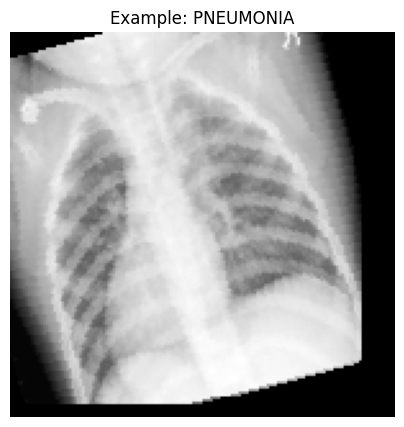

In [14]:
# Augmentations (grayscale pipeline)
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # simple symmetric norm
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "valid")
test_dir  = os.path.join(DATA_DIR, "test")

train_set = datasets.ImageFolder(train_dir, transform=train_tf)
val_set   = datasets.ImageFolder(val_dir,   transform=eval_tf)
test_set  = datasets.ImageFolder(test_dir,  transform=eval_tf)

class_names = train_set.classes  # alphabetical (likely ['NORMAL', 'PNEUMONIA'])
class_to_idx = train_set.class_to_idx
print("Classes:", class_names)
print("Class->Index:", class_to_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Optional: show a sample (comment out on headless runs)
x0, y0 = next(iter(train_loader))
plt.figure(figsize=(5,5))
plt.imshow(np.squeeze((x0[0].permute(1,2,0).numpy()*0.5 + 0.5)), cmap='gray')
plt.title(f"Example: {class_names[y0[0]]}")
plt.axis("off")
plt.show()

In [15]:
# %%
class PneumoniaCNN(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,  32, kernel_size=3, stride=1, padding=1)  # -> 150x150
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # -> 75x75

        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.drop2 = nn.Dropout(0.1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # -> 37x37

        self.conv3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3   = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # -> 18x18

        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.drop4 = nn.Dropout(0.2)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)  # -> 9x9

        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.drop5 = nn.Dropout(0.2)
        self.bn5   = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)  # -> 4x4

        self.flat  = nn.Flatten()
        self.fc1   = nn.Linear(256*4*4, 128)
        self.dropf = nn.Dropout(0.2)
        self.head  = nn.Linear(128, 1)  # single logit

    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.bn1(x); x = self.pool1(x)
        x = F.relu(self.conv2(x)); x = self.drop2(x); x = self.bn2(x); x = self.pool2(x)
        x = F.relu(self.conv3(x)); x = self.bn3(x); x = self.pool3(x)
        x = F.relu(self.conv4(x)); x = self.drop4(x); x = self.bn4(x); x = self.pool4(x)
        x = F.relu(self.conv5(x)); x = self.drop5(x); x = self.bn5(x); x = self.pool5(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x)); x = self.dropf(x)
        logits = self.head(x)  # shape [B,1]
        return logits

model = PneumoniaCNN(in_ch=1).to(DEVICE)
print(model)

PneumoniaCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop2): Dropout(p=0.1, inplace=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop4): Dropout(p=0.2, inplace=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [16]:
# %%
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=INIT_LR)

# Reduce LR when val accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.3, patience=2, min_lr=1e-6
)

def binary_batch_metrics(logits, targets):
    # logits: [B,1], targets: [B] {0,1}
    probs = torch.sigmoid(logits).detach()
    preds = (probs >= 0.5).long().view(-1)
    correct = (preds.cpu() == targets.cpu()).sum().item()
    return correct, preds.cpu().numpy(), probs.cpu().numpy()

In [17]:
# %%
def run_epoch(loader, training:bool=True) -> Dict[str, Any]:
    model.train(training)
    total_loss, total_correct, total_examples = 0.0, 0, 0
    all_preds, all_probs, all_targets = [], [], []

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE).float()  # float for BCEWithLogitsLoss

        if training:
            optimizer.zero_grad()

        logits = model(x).squeeze(1)  # [B]
        loss = criterion(logits, y)

        if training:
            loss.backward()
            optimizer.step()

        correct, preds_np, probs_np = binary_batch_metrics(logits.unsqueeze(1), y.long())
        total_loss += loss.item() * x.size(0)
        total_correct += correct
        total_examples += x.size(0)

        all_preds.append(preds_np)
        all_probs.append(probs_np)
        all_targets.append(y.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total_examples)
    acc = total_correct / max(1, total_examples)
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    y_prob = np.concatenate(all_probs).ravel()

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    # AUC requires both classes present; handle edge cases
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    return {
        "loss": avg_loss, "acc": acc,
        "precision":prec, "recall":rec, "f1":f1, "auc": auc,
        "y_true": y_true, "y_pred": y_pred, "y_prob": y_prob
    }

In [18]:
# -------------------- Training loop with Early Stopping & Checkpoint --------------------
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[], "val_auc":[]}

best_val_acc = -np.inf
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    train_out = run_epoch(train_loader, training=True)
    val_out   = run_epoch(val_loader,   training=False)

    history["train_loss"].append(train_out["loss"])
    history["val_loss"].append(val_out["loss"])
    history["train_acc"].append(train_out["acc"])
    history["val_acc"].append(val_out["acc"])
    history["train_f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["val_auc"].append(val_out["auc"])

    # Step LR scheduler on validation accuracy
    scheduler.step(val_out["acc"])

    # ----- Checkpoint: save best-by-val-accuracy -----
    improved = val_out["acc"] > (best_val_acc + ES_MIN_DELTA)
    if improved:
        best_val_acc = val_out["acc"]
        epochs_no_improve = 0
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "classes": class_names,
                "img_size": IMG_SIZE,
                "val_metrics": {
                    "acc": val_out["acc"],
                    "precision": val_out["precision"],
                    "recall": val_out["recall"],
                    "f1": val_out["f1"],
                    "auc": val_out["auc"],
                },
                "arch": "PneumoniaCNN(in_ch=1)"
            },
            BEST_MODEL_PATH
        )
    else:
        epochs_no_improve += 1

    print(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"| train_loss={train_out['loss']:.4f} acc={train_out['acc']:.4f} f1={train_out['f1']:.4f} "
        f"| val_loss={val_out['loss']:.4f} acc={val_out['acc']:.4f} f1={val_out['f1']:.4f} auc={val_out['auc']:.4f} "
        f"| lr={optimizer.param_groups[0]['lr']:.6f} "
        f"| {'*BEST*' if improved else ''} "
        f"| {time.time()-t0:.1f}s"
    )

    # ----- Early stopping -----
    if epochs_no_improve >= ES_PATIENCE:
        print(f"\n[EarlyStopping] No val acc improvement ≥ {ES_MIN_DELTA} for {ES_PATIENCE} epochs. Stopping.")
        break

# Always save a "last" checkpoint
torch.save(
    {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "classes": class_names,
        "img_size": IMG_SIZE,
        "arch": "PneumoniaCNN(in_ch=1)"
    },
    LAST_MODEL_PATH
)
print(f"\n[Checkpoint] Best-by-Acc saved to: {BEST_MODEL_PATH}")
print(f"[Checkpoint] Last model saved to:   {LAST_MODEL_PATH}")

Epoch 01/50 | train_loss=0.3235 acc=0.8788 f1=0.9167 | val_loss=0.1387 acc=0.9442 f1=0.9617 auc=0.9863 | lr=0.001000 | *BEST* | 22.8s
Epoch 02/50 | train_loss=0.2073 acc=0.9240 f1=0.9481 | val_loss=0.1953 acc=0.9236 f1=0.9469 auc=0.9799 | lr=0.001000 |  | 21.2s
Epoch 03/50 | train_loss=0.1722 acc=0.9379 f1=0.9576 | val_loss=0.1205 acc=0.9528 f1=0.9677 auc=0.9891 | lr=0.001000 | *BEST* | 21.2s
Epoch 04/50 | train_loss=0.1527 acc=0.9436 f1=0.9615 | val_loss=0.1202 acc=0.9588 f1=0.9719 auc=0.9888 | lr=0.001000 | *BEST* | 21.3s
Epoch 05/50 | train_loss=0.1449 acc=0.9482 f1=0.9646 | val_loss=0.1125 acc=0.9597 f1=0.9726 auc=0.9909 | lr=0.001000 |  | 21.1s
Epoch 06/50 | train_loss=0.1308 acc=0.9514 f1=0.9668 | val_loss=0.1850 acc=0.9202 f1=0.9484 auc=0.9860 | lr=0.001000 |  | 21.2s
Epoch 07/50 | train_loss=0.1270 acc=0.9527 f1=0.9677 | val_loss=0.3619 acc=0.8532 f1=0.8902 auc=0.9908 | lr=0.001000 |  | 21.3s
Epoch 08/50 | train_loss=0.1225 acc=0.9549 f1=0.9691 | val_loss=0.0879 acc=0.9674 f1=0

In [19]:
# %% Evaluate on Test (using current model state; you can also load BEST_MODEL_PATH)
model.eval()
test_out = run_epoch(test_loader, training=False)

print("\n==== Test metrics ====")
print(f"  Loss: {test_out['loss']:.4f}")
print(f"  Acc : {100*test_out['acc']:.2f}%")
print(f"  Prec: {100*test_out['precision']:.2f}%")
print(f"  Rec : {100*test_out['recall']:.2f}%")
print(f"  F1  : {100*test_out['f1']:.2f}%")
try:
    print(f"  AUC : {100*test_out['auc']:.2f}%")
except:
    print("  AUC : nan")

print("\nClassification report:")
print(classification_report(test_out["y_true"], test_out["y_pred"], target_names=class_names, zero_division=0))

# Save test metrics to CSV for record
pd.DataFrame([{
    "acc": test_out["acc"],
    "precision": test_out["precision"],
    "recall": test_out["recall"],
    "f1": test_out["f1"],
    "auc": test_out["auc"],
    "loss": test_out["loss"],
}]).to_csv(os.path.join(MODELS_DIR, "test_metrics.csv"), index=False)


==== Test metrics ====
  Loss: 0.1321
  Acc : 95.19%
  Prec: 97.99%
  Rec : 95.13%
  F1  : 96.54%
  AUC : 99.16%

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.89      0.95      0.92       171
   PNEUMONIA       0.98      0.95      0.97       411

    accuracy                           0.95       582
   macro avg       0.94      0.95      0.94       582
weighted avg       0.95      0.95      0.95       582



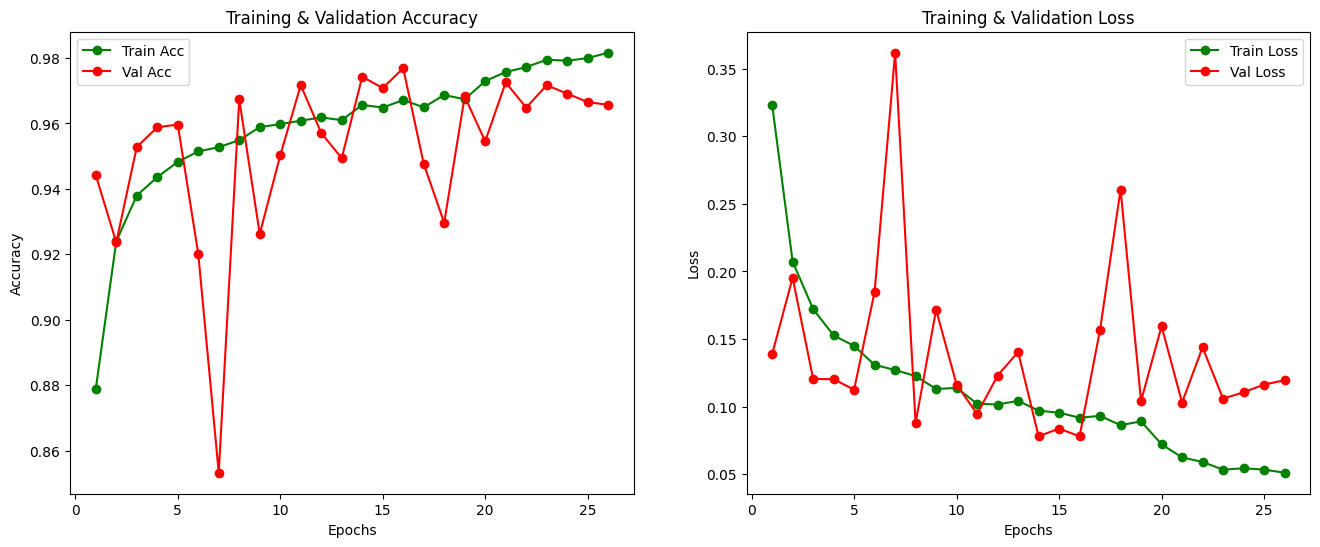

In [20]:
# ## Training Curves (Accuracy & Loss)

# %%
epochs_ran = list(range(1, len(history["train_loss"])+1))
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].plot(epochs_ran, history["train_acc"], "go-", label="Train Acc")
ax[0].plot(epochs_ran, history["val_acc"],   "ro-", label="Val Acc")
ax[0].set_title("Training & Validation Accuracy"); ax[0].legend()
ax[0].set_xlabel("Epochs"); ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs_ran, history["train_loss"], "g-o", label="Train Loss")
ax[1].plot(epochs_ran, history["val_loss"],   "r-o", label="Val Loss")
ax[1].set_title("Training & Validation Loss"); ax[1].legend()
ax[1].set_xlabel("Epochs"); ax[1].set_ylabel("Loss")
plt.show()

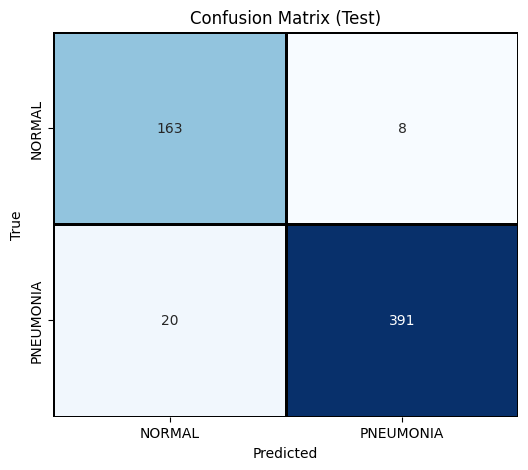

In [21]:
# %% Confusion Matrix (Test)
cm = confusion_matrix(test_out["y_true"], test_out["y_pred"])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d", cbar=False, linewidths=1, linecolor="black")
plt.title("Confusion Matrix (Test)")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.show()

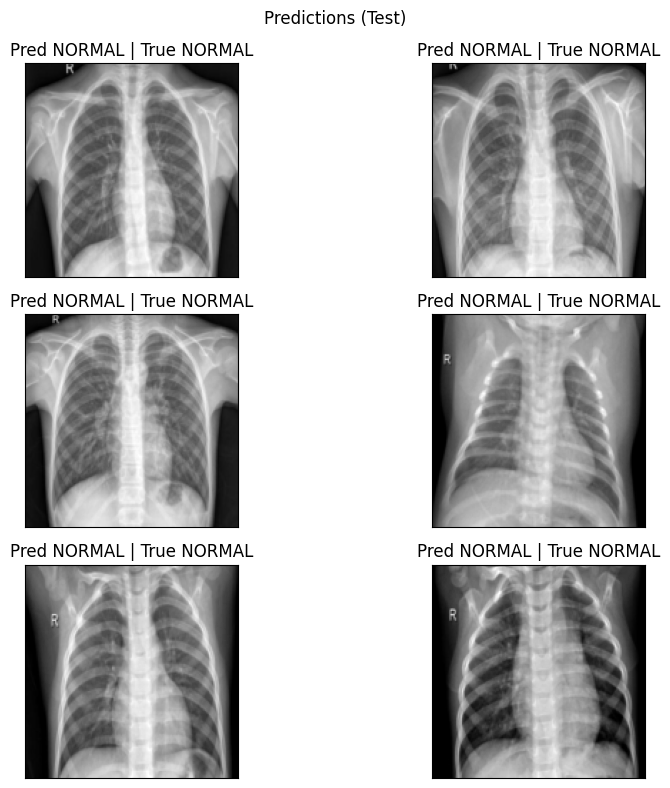

In [24]:
# %%
# Get indices of correct/incorrect on the test set
correct_idx = np.where(test_out["y_pred"] == test_out["y_true"])[0]

# To visualize images, we need access again to images (iterate the loader and cache a list)
test_images = []
test_labels = []
for x, y in test_loader:
    test_images.append(x)  # normalized tensor
    test_labels.append(y)
test_images = torch.cat(test_images, dim=0)
test_labels = torch.cat(test_labels, dim=0)

def denorm(img):
    # undo Normalize(mean=[0.5], std=[0.5])
    img = img * 0.5 + 0.5
    return img.clamp(0,1)

def show_grid(indices, title):
    n = min(6, len(indices))
    if n == 0:
        print(f"No images to display for {title}.")
        return
    plt.figure(figsize=(10,8))
    for i in range(n):
        idx = indices[i]
        plt.subplot(3,2,i+1)
        disp = denorm(test_images[idx]).squeeze(0).cpu().numpy()
        plt.imshow(disp, cmap="gray")
        plt.xticks([]); plt.yticks([])
        plt.title(f"Pred {class_names[int(test_out['y_pred'][idx])]} | True {class_names[int(test_out['y_true'][idx])]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(correct_idx[:6], "Predictions (Test)")